# (Almost) Grover Adaptive Search

You may always refer to [qiskit implementation](https://qiskit.org/documentation/optimization/tutorials/04_grover_optimizer.html) of GAS. This code is suitable for any problem in a QUBO form.

<img src="https://miro.medium.com/max/1400/1*qqsXD-J-ydhIGv7qKiZQkg.png" width="300"/>.

You may want to learn how to converts optimization problems into QUBO format. And there is a [good tutorial](https://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf) for this. 


But in this file we will implement our own simple oracle.

## Oracle

Let us assume we collect a knapsack with the items where COST = WEIGHT. This will allow us to save some qubits and thus run a faster simulation.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import DensityMatrix
from qiskit.extensions import UnitaryGate

def _adder_subcircuit(n_qubits):
    from qiskit.circuit.library import XGate
    qc = QuantumCircuit(n_qubits, name=f"+1[{n_qubits}]")
    for i in range(n_qubits, 1, -1):
        cx = XGate().control(i - 1)
        qc.append(cx, range(i))
    qc.x(0)
    return qc

def get_plus(value, n_qubits):
    qc = QuantumCircuit(n_qubits, name=f"+{value}")
    if value == 0:
        return qc
    if value < 0:
        return get_plus(-value, n_qubits).inverse()  
    counter = 0
    while value > 0:
        if value % 2 == 1:
            qc.append(_adder_subcircuit(n_qubits - counter), range(counter, n_qubits))
        value //= 2
        counter += 1
    # here we transpile in advanse to use to_gate() method further in a call
    return transpile(qc, BasicAer.get_backend('qasm_simulator'))

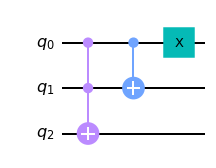

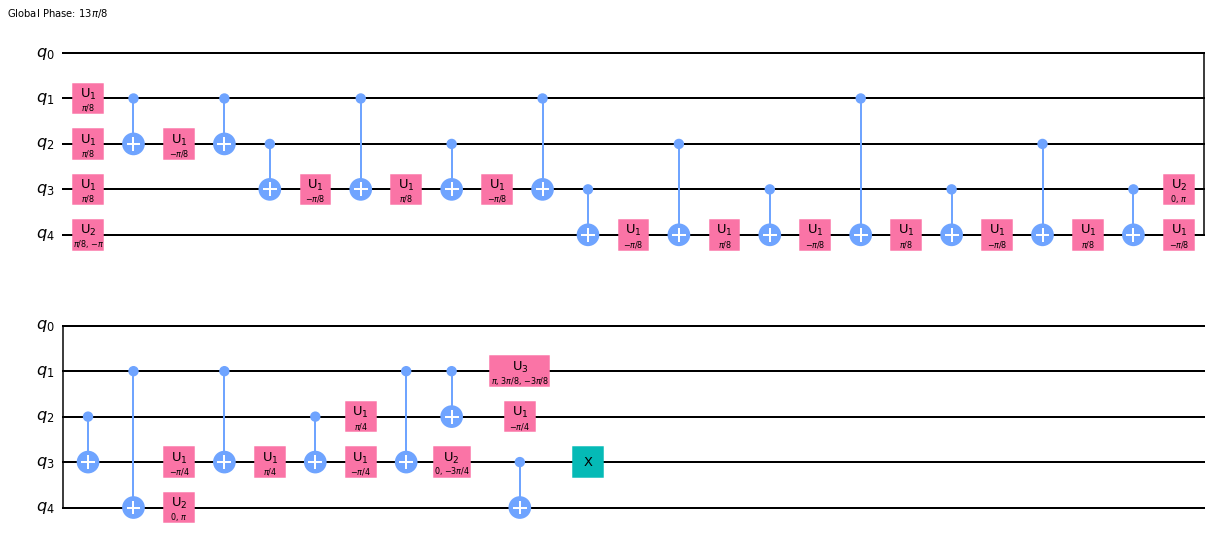

In [2]:
display(_adder_subcircuit(3).draw('mpl'))
display(get_plus(10, n_qubits=5).draw('mpl'))

# Knapasack constraints definition

Let there be the set of items:

`[3, 6, 2, 7, 1]`

with the capacity of 11 and initial cost estimation as 8 (don't ask why :), ok, ask).

Implement the function, which will collect a sum in the register `cost_register` given a register of `items_register`. And also undo this.

In [3]:
def count_sum(circuit, items_register, costs, cost_register):
    for qubit, cost in zip(items_register, costs):
        plus = get_plus(cost, len(cost_register)).to_gate().control(1)
        circuit.append(plus, [qubit] + cost_register[:])
        
def uncount_sum(circuit, items_register, costs, cost_register):
    # TODO: undo the actions performed by the function above

Let us check the controlled sum is constructed as expected.

In [14]:
qc = QuantumCircuit(6)
count_sum(qc, 
              items_register=[0, 1, 2], 
              costs=[6, 5, 2], 
              cost_register=[3, 4, 5])
qc.draw()

q_0: ───■─────────────────
        │                 
q_1: ───┼──────■──────────
        │      │          
q_2: ───┼──────┼──────■───
     ┌──┴──┐┌──┴──┐┌──┴──┐
q_3: ┤0    ├┤0    ├┤0    ├
     │     ││     ││     │
q_4: ┤1 +6 ├┤1 +5 ├┤1 +2 ├
     │     ││     ││     │
q_5: ┤2    ├┤2    ├┤2    ├
     └─────┘└─────┘└─────┘

In [18]:
import math

def construct_oracle(costs, more_than, capacity):
    
    # how many qubits do we need?
    n_qubits = len(costs)
    n_cost_qubits = math.ceil(math.log2(sum(costs))) + 1
    print("Cost qubits:", n_cost_qubits, "Items qubits:", n_qubits)
    
    # compose a circuit
    items_register = QuantumRegister(n_qubits)
    cost_register = QuantumRegister(n_cost_qubits)
    target = QuantumRegister(1)
    qc = QuantumCircuit(items_register, cost_register, target)

    # first we compute a conditional sum
    count_sum(qc, items_register, costs, cost_register)
    qc.barrier()
    
    # in a target qubit we will implement the controlled not functionality
    # set truth to True. No constraints violated by now
    qc.x(target)
    qc.barrier()    
    
    # condition on cost estimation. If number is less -- we violate the condition, undo x.
    # COST > more_than 
    # TO VIOLATE condition: 
    # COST - more_than <= 0      
    # ----->      (COST - more_than - 1) < 0. In this case we apply apply CX
    qc.append(get_plus(-(more_than + 1), len(cost_register)), cost_register)
    qc.cx(cost_register[-1], target)
    qc.append(get_plus((more_than + 1), len(cost_register)), cost_register)
    qc.barrier()    
    
    # condition COST <= capacity
    # TO VIOLATE: COST - capacity > 0
    # ----->      (COST - capacity - 1 >= 0) or NOT(COST - capacity - 1 < 0) 
    # use x to flip the condition!
    
    # TODO!!!!!!

    qc.barrier()
    uncount_sum(qc, items_register, costs, cost_register)
    
    return qc

Cost qubits: 6 Items qubits: 5


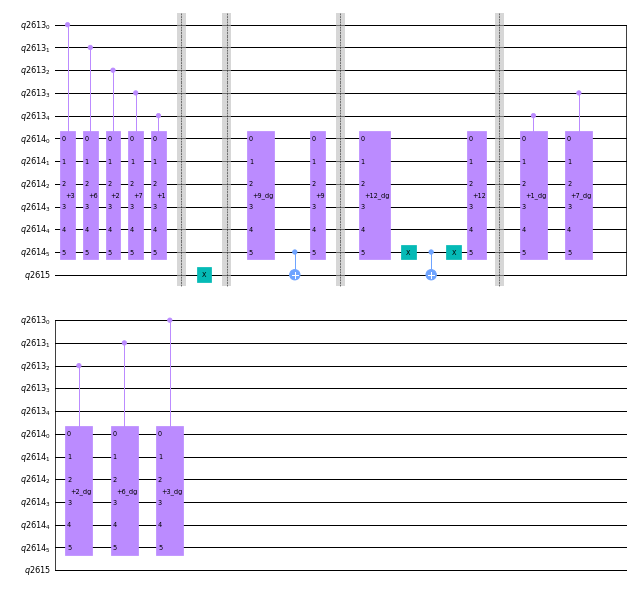

In [19]:
qc = construct_oracle([3, 6, 2, 7, 1], 8, 11)
qc.draw('mpl', scale=.5)

Test the oracle. Does it work correctly?

Cost qubits: 6 Items qubits: 5


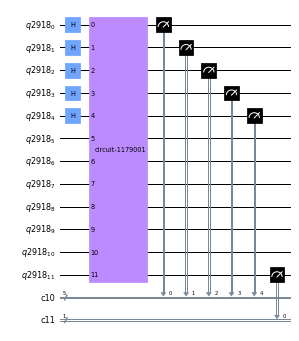

{'0 01011': 7,
 '0 01110': 5,
 '0 00110': 15,
 '0 00001': 9,
 '0 01101': 6,
 '1 11001': 7,
 '0 11000': 14,
 '0 01000': 5,
 '0 00000': 5,
 '0 10001': 3,
 '1 00111': 11,
 '1 01001': 6,
 '1 01100': 8,
 '0 11110': 9,
 '0 00010': 6,
 '1 10011': 10,
 '1 00011': 10,
 '0 00101': 5,
 '0 01111': 4,
 '0 00100': 4,
 '0 01010': 5,
 '0 11111': 3,
 '0 11010': 4,
 '0 10000': 5,
 '0 11011': 3,
 '1 10110': 6,
 '0 10111': 5,
 '0 10010': 7,
 '0 10100': 3,
 '0 11101': 3,
 '0 10101': 3,
 '1 11100': 4}

In [20]:
# test the oracle
data = [3, 6, 2, 7, 1]

qc = QuantumCircuit(QuantumRegister(12), ClassicalRegister(5), ClassicalRegister(1))
qc.h(range(5))
qc.append(
    construct_oracle(data, 8, 11),
    range(12)
)
qc.measure(range(5), range(5))
qc.measure([11], [5])

display(qc.draw('mpl', scale=.5))
counts = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=200).result().get_counts()
counts

### We can create a diffuser even like this!

In [21]:
import numpy as np
# https://qiskit.org/documentation/stubs/qiskit.circuit.library.GroverOperator.html
diffuse_operator = 2 * Operator((1 / 32.) *  np.ones((32, 32))) - Operator.from_label('I' * 5)

### TODO: Implement a method which will (given a measurement), return weight (cost) value.

In [22]:
def weight(key, data):
    # TODO

## Grover it!
We are ready to give Grover a chance.

Cost qubits: 6 Items qubits: 5


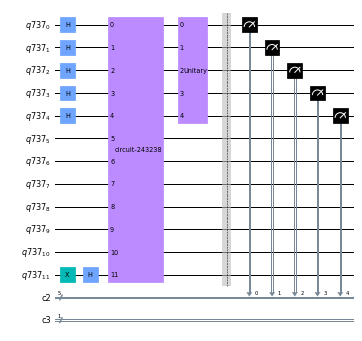

{'0 00011': 21, '0 10110': 26, '0 11100': 27, '0 01001': 34, '0 01100': 22, '0 11001': 13, '0 00111': 32, '0 10011': 25}
0 00011  :>  9
0 10110  :>  9
0 11100  :>  10
0 01001  :>  10
0 01100  :>  9
0 11001  :>  11
0 00111  :>  11
0 10011  :>  10


In [10]:
# test the oracle
data = [3, 6, 2, 7, 1]

qc = QuantumCircuit(QuantumRegister(12), ClassicalRegister(5), ClassicalRegister(1))

qc.x(-1)
qc.h(-1)

o = construct_oracle(data, 8, 11)

qc.h(range(5))
qc.append(o, range(12))
qc.append(diffuse_operator, range(5))
qc.barrier()
qc.measure(range(5), range(5))

display(qc.draw('mpl', scale=.5))
counts = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=200).result().get_counts()
print(counts)
for key in counts:
    print(key, " :> ", weight(key, data))

In [11]:
data = [3, 6, 2, 7, 1]
low, high = 8, 11
solution = None

while low + 1 <= high:
    print(f"Seeking bigger $ than {low} for capacity {high}")
    qc = QuantumCircuit(QuantumRegister(12), ClassicalRegister(5), ClassicalRegister(1))
    qc.x(-1)
    qc.h(-1)
    o = construct_oracle(data, low, high)
    
    qc.h(range(5))
    
    # XXX: here should be an iterative process on the number of iterations!
    # but we will run it once always
    qc.append(o, range(12))
    qc.append(diffuse_operator, range(5))
    qc.barrier()
    qc.measure(range(5), range(5))
    
    # one shot, one opportunity comes ones in the lifetime.
    counts = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=1).result().get_counts()
    
    print(counts)
    
    key = list(counts.keys())[0]
    w = weight(key, data)
    
    if w <= low or w > high:
        # XXX retry process is a little more complicated in GAS. If our capacity is unreachable, the algorithms may never converge
        # here we may have a fallback action
        print("This iteration failed. Retry")
    else:
        print(f"Found {key} with cost {w}")
        low = w
        solution = key
        
        
print("Solution: ", solution)

Seeking bigger $ than 8 for capacity 11
Cost qubits: 6 Items qubits: 5
{'0 01100': 1}
Found 0 01100 with cost 9
Seeking bigger $ than 9 for capacity 11
Cost qubits: 6 Items qubits: 5
{'0 00111': 1}
Found 0 00111 with cost 11
Solution:  0 00111
